✅ Librerías importadas correctamente

🎯 INSTRUCCIONES DE USO:

1. Asegúrate de tener tu archivo CSV con los datos limpios de ONGs
2. Ejecuta todas las celdas hasta aquí
3. Llama a la función principal:

   embedding_system, df = main_embedding_system('ongs_procesadas.csv')

4. Para hacer búsquedas personalizadas:

   # Ejemplo de búsqueda
   resultados = embedding_system.search_similar_ongs("quiero ayudar con educación", top_k=5)

   for resultado in resultados:
       print(f"ONG: {resultado['nombre']}")
       print(f"Similitud: {resultado['similitud']:.3f}")
       print(f"Misión: {resultado['mision']}")
       print()

5. El sistema estará listo para integrar con el chatbot! 🤖

NOTA: La primera vez que ejecutes tardará unos minutos en descargar
el modelo de embeddings.

🚀 SISTEMA DE EMBEDDINGS PARA ONGs
📂 Cargando datos de ONGs...
📊 Cargadas 36 ONGs

📋 Campos disponibles:
  nombre: 100.0% completo
  mensaje_descriptivo: 97.2% completo
  presentacion: 91.7% completo
  quienes_son: 1

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Embeddings generados: (36, 384)
🔍 ANÁLISIS DE EMBEDDINGS
📊 Dimensiones de embeddings: (36, 384)
📊 Similitud promedio entre ONGs: 0.377
📊 Similitud máxima: 1.000
📊 Similitud mínima: 0.060


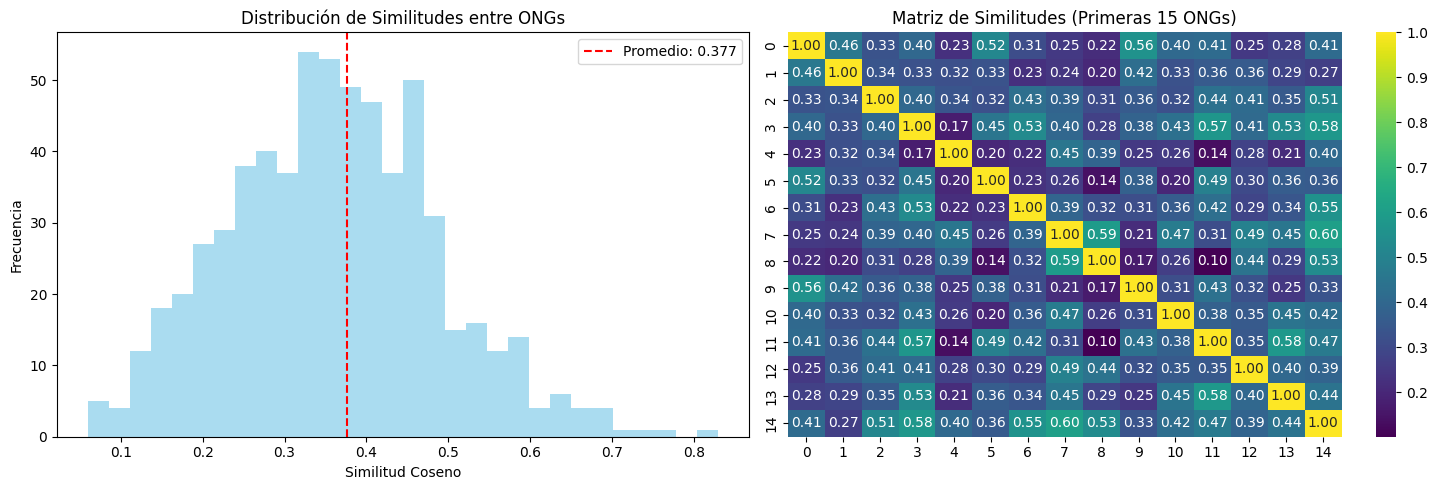

🧪 PRUEBAS DEL SISTEMA DE BÚSQUEDA

🔍 CONSULTA 1: 'Necesito ayuda con educación para niños'
----------------------------------------
1. asociación civil terapia para niños tandil (Similitud: 0.564)
   Misión: nuestra misión es potenciar la terapia intensiva pediátrica, para la salud pública. crear y apoyar programas para mejorar la salud y el bienestar de los niños y su entorno, brindando contención y dand...

2. asociación civil salir adelante conin tandil (Similitud: 0.548)
   Misión: prevenir y revertir la desnutrición infantil en tandil, mediante la metodología conin, que propone una asistencia integral interdisciplinaria a la madre y su hijo, desde la gestación hasta los 5 años ...

3. comedor los nietos (Similitud: 0.528)
   Misión: el fin es proporcionar la alimentación adecuada a aquellos niños que por diferentes razones no cuentan con los recursos y/o medios para acceder esta necesidad básica.

------------------------------------------------------------

🔍 CONSULTA 2: 'Quiero 

In [ ]:
# Sistema de Embeddings y Búsqueda Semántica para ONGs
# Proyecto: Sistema de Recomendación de ONGs con IA

# ============================================================================
# INSTALACIÓN DE LIBRERÍAS
# ============================================================================

!pip install sentence-transformers scikit-learn pandas numpy matplotlib seaborn
!pip install transformers torch

# ============================================================================
# IMPORTACIONES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import re
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías importadas correctamente")

# ============================================================================
# CARGA Y PREPARACIÓN DE DATOS
# ============================================================================

def load_and_prepare_data(csv_path):
    """
    Carga los datos de ONGs y prepara el texto combinado para embeddings
    """
    print("📂 Cargando datos de ONGs...")

    # Cargar datos
    df = pd.read_csv(csv_path)
    print(f"📊 Cargadas {len(df)} ONGs")

    # Mostrar información básica
    print("\n📋 Campos disponibles:")
    for col in df.columns:
        non_empty = df[col].notna() & (df[col] != '') & (df[col] != ' ')
        completitud = (non_empty.sum() / len(df)) * 100
        print(f"  {col}: {completitud:.1f}% completo")

    return df

def create_combined_text(df):
    """
    Combina los campos más informativos en un texto único para cada ONG
    """
    print("\n🔗 Creando texto combinado para embeddings...")

    def combine_fields(row):
        # Campos principales a combinar (priorizando los más poblados)
        fields_to_combine = {
            'nombre': 3,  # Peso 3 - muy importante
            'mision': 2,  # Peso 2 - muy importante
            'vision': 2,  # Peso 2 - muy importante
            'servicios': 1.5,  # Peso 1.5 - importante
            'presentacion': 1.5,
            'que_ofrece': 1.5,
            'quienes_son': 1,
            'poblacion_beneficiaria': 1,
            'categoria': 1,
            'ubicacion': 0.5  # Peso 0.5 - menos importante para similitud semántica
        }

        combined_parts = []

        for field, weight in fields_to_combine.items():
            if field in row and pd.notna(row[field]) and str(row[field]).strip():
                text = str(row[field]).strip()
                # Repetir el texto según su peso (aproximado)
                repetitions = int(weight)
                for _ in range(repetitions):
                    combined_parts.append(text)

        return ' '.join(combined_parts)

    # Aplicar combinación
    df['texto_combinado'] = df.apply(combine_fields, axis=1)

    # Estadísticas del texto combinado
    text_lengths = df['texto_combinado'].str.len()
    print(f"📏 Longitud promedio del texto combinado: {text_lengths.mean():.0f} caracteres")
    print(f"📏 Rango: {text_lengths.min():.0f} - {text_lengths.max():.0f} caracteres")

    return df

# ============================================================================
# SISTEMA DE EMBEDDINGS
# ============================================================================

class ONGEmbeddingSystem:
    def __init__(self, model_name='paraphrase-multilingual-MiniLM-L12-v2'):
        """
        Inicializa el sistema de embeddings
        model_name: Modelo de Sentence Transformers a usar
        """
        print(f"🤖 Cargando modelo: {model_name}")
        self.model = SentenceTransformer(model_name)
        self.embeddings = None
        self.df = None

    def fit(self, df):
        """
        Entrena el sistema con los datos de ONGs
        """
        print("🚀 Generando embeddings para las ONGs...")
        self.df = df.copy()

        # Generar embeddings
        texts = df['texto_combinado'].tolist()
        self.embeddings = self.model.encode(texts,
                                          show_progress_bar=True,
                                          convert_to_tensor=False)

        print(f"✅ Embeddings generados: {self.embeddings.shape}")
        return self

    def search_similar_ongs(self, query, top_k=5, threshold=0.1):
        """
        Busca ONGs similares a una consulta
        """
        if self.embeddings is None:
            raise ValueError("El sistema no ha sido entrenado. Ejecuta fit() primero.")

        # Generar embedding de la consulta
        query_embedding = self.model.encode([query])

        # Calcular similitudes
        similarities = cosine_similarity(query_embedding, self.embeddings)[0]

        # Obtener índices ordenados por similitud
        similar_indices = np.argsort(similarities)[::-1]

        # Filtrar por threshold y top_k
        results = []
        for idx in similar_indices[:top_k]:
            if similarities[idx] >= threshold:
                results.append({
                    'indice': idx,
                    'nombre': self.df.iloc[idx]['nombre'],
                    'mision': self.df.iloc[idx]['mision'][:200] + '...' if len(str(self.df.iloc[idx]['mision'])) > 200 else self.df.iloc[idx]['mision'],
                    'similitud': similarities[idx],
                    'ong_completa': self.df.iloc[idx]
                })

        return results

    def get_embedding_stats(self):
        """
        Obtiene estadísticas de los embeddings
        """
        if self.embeddings is None:
            return None

        # Calcular matriz de similitudes entre todas las ONGs
        similarity_matrix = cosine_similarity(self.embeddings)

        # Estadísticas
        stats = {
            'dimensiones': self.embeddings.shape,
            'similitud_promedio': np.mean(similarity_matrix),
            'similitud_max': np.max(similarity_matrix[similarity_matrix < 1.0]),  # Excluir diagonal
            'similitud_min': np.min(similarity_matrix),
            'varianza_similitud': np.var(similarity_matrix)
        }

        return stats, similarity_matrix

# ============================================================================
# FUNCIONES DE ANÁLISIS Y VISUALIZACIÓN
# ============================================================================

def analyze_embeddings(embedding_system):
    """
    Analiza y visualiza los embeddings generados
    """
    print("🔍 ANÁLISIS DE EMBEDDINGS")
    print("=" * 50)

    stats, similarity_matrix = embedding_system.get_embedding_stats()

    print(f"📊 Dimensiones de embeddings: {stats['dimensiones']}")
    print(f"📊 Similitud promedio entre ONGs: {stats['similitud_promedio']:.3f}")
    print(f"📊 Similitud máxima: {stats['similitud_max']:.3f}")
    print(f"📊 Similitud mínima: {stats['similitud_min']:.3f}")

    # Visualizar distribución de similitudes
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Histograma de similitudes
    similarities_flat = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
    axes[0].hist(similarities_flat, bins=30, alpha=0.7, color='skyblue')
    axes[0].set_xlabel('Similitud Coseno')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title('Distribución de Similitudes entre ONGs')
    axes[0].axvline(stats['similitud_promedio'], color='red', linestyle='--', label=f'Promedio: {stats["similitud_promedio"]:.3f}')
    axes[0].legend()

    # Heatmap de similitudes (muestra solo primeras 15 ONGs para legibilidad)
    n_show = min(15, len(similarity_matrix))
    sns.heatmap(similarity_matrix[:n_show, :n_show],
                annot=True, fmt='.2f', cmap='viridis',
                ax=axes[1])
    axes[1].set_title(f'Matriz de Similitudes (Primeras {n_show} ONGs)')

    plt.tight_layout()
    plt.show()

def test_search_system(embedding_system, test_queries):
    """
    Prueba el sistema con consultas de ejemplo
    """
    print("🧪 PRUEBAS DEL SISTEMA DE BÚSQUEDA")
    print("=" * 60)

    for i, query in enumerate(test_queries, 1):
        print(f"\n🔍 CONSULTA {i}: '{query}'")
        print("-" * 40)

        results = embedding_system.search_similar_ongs(query, top_k=3)

        if results:
            for j, result in enumerate(results, 1):
                print(f"{j}. {result['nombre']} (Similitud: {result['similitud']:.3f})")
                print(f"   Misión: {result['mision']}")
                print()
        else:
            print("   No se encontraron ONGs similares")

        print("-" * 60)

def create_ong_profiles(df):
    """
    Crea perfiles resumidos de las ONGs para mejor comprensión
    """
    print("📋 PERFILES DE ONGs EN EL DATASET")
    print("=" * 50)

    for i, row in df.iterrows():
        if i >= 5:  # Mostrar solo las primeras 5
            break

        print(f"\n🏢 {row['nombre']}")

        if pd.notna(row['mision']) and row['mision']:
            print(f"📝 Misión: {str(row['mision'])[:150]}...")

        if pd.notna(row['categoria']) and row['categoria']:
            print(f"🏷️ Categoría: {row['categoria']}")

        if pd.notna(row['ubicacion']) and row['ubicacion']:
            print(f"📍 Ubicación: {row['ubicacion']}")

        print("-" * 30)

# ============================================================================
# FUNCIÓN PRINCIPAL
# ============================================================================

def main_embedding_system(csv_path):
    """
    Función principal para crear y probar el sistema de embeddings
    """
    print("🚀 SISTEMA DE EMBEDDINGS PARA ONGs")
    print("=" * 60)

    # 1. Cargar y preparar datos
    df = load_and_prepare_data(csv_path)
    df = create_combined_text(df)

    # 2. Mostrar perfiles de ejemplo
    create_ong_profiles(df)

    # 3. Crear sistema de embeddings
    embedding_system = ONGEmbeddingSystem()
    embedding_system.fit(df)

    # 4. Analizar embeddings
    analyze_embeddings(embedding_system)

    # 5. Probar con consultas de ejemplo
    test_queries = [
        "Necesito ayuda con educación para niños",
        "Quiero colaborar con medio ambiente",
        "Busco ONGs que trabajen con adultos mayores",
        "Organizaciones que ayuden con salud mental",
        "ONGs que trabajen con discapacidad"
    ]

    test_search_system(embedding_system, test_queries)

    print("✅ Sistema de embeddings creado y probado exitosamente!")

    return embedding_system, df

# ============================================================================
# INSTRUCCIONES DE USO
# ============================================================================

print("""
🎯 INSTRUCCIONES DE USO:

1. Asegúrate de tener tu archivo CSV con los datos limpios de ONGs
2. Ejecuta todas las celdas hasta aquí
3. Llama a la función principal:

   embedding_system, df = main_embedding_system('ongs_procesadas.csv')

4. Para hacer búsquedas personalizadas:

   # Ejemplo de búsqueda
   resultados = embedding_system.search_similar_ongs("quiero ayudar con educación", top_k=5)

   for resultado in resultados:
       print(f"ONG: {resultado['nombre']}")
       print(f"Similitud: {resultado['similitud']:.3f}")
       print(f"Misión: {resultado['mision']}")
       print()

5. El sistema estará listo para integrar con el chatbot! 🤖

NOTA: La primera vez que ejecutes tardará unos minutos en descargar
el modelo de embeddings.
""")

# ============================================================================
# FUNCIONES ADICIONALES PARA EXPERIMENTAR
# ============================================================================

def interactive_search(embedding_system):
    """
    Función interactiva para probar búsquedas
    """
    print("🔍 BÚSQUEDA INTERACTIVA")
    print("Escribe 'salir' para terminar")
    print("-" * 30)

    while True:
        query = input("\n💬 ¿Qué tipo de ONG buscas? ")

        if query.lower() in ['salir', 'exit', 'quit']:
            print("¡Hasta luego! 👋")
            break

        if not query.strip():
            continue

        results = embedding_system.search_similar_ongs(query, top_k=3)

        if results:
            print(f"\n🎯 Encontré {len(results)} ONGs relevantes:")
            for i, result in enumerate(results, 1):
                print(f"\n{i}. 🏢 {result['nombre']}")
                print(f"   📊 Relevancia: {result['similitud']:.1%}")
                print(f"   📝 {result['mision']}")
        else:
            print("❌ No encontré ONGs que coincidan con tu búsqueda")

def compare_models(df, models_to_test=['paraphrase-multilingual-MiniLM-L12-v2', 'distiluse-base-multilingual-cased']):
    """
    Compara diferentes modelos de embeddings
    """
    print("⚖️ COMPARACIÓN DE MODELOS")
    print("=" * 40)

    results = {}

    for model_name in models_to_test:
        print(f"\n🧪 Probando modelo: {model_name}")

        try:
            system = ONGEmbeddingSystem(model_name)
            system.fit(df)

            stats, _ = system.get_embedding_stats()
            results[model_name] = stats

            print(f"✅ Completado - Similitud promedio: {stats['similitud_promedio']:.3f}")

        except Exception as e:
            print(f"❌ Error con {model_name}: {str(e)}")

    return results


embedding_system, df = main_embedding_system('ongs_procesadas.csv')

In [ ]:
interactive_search(embedding_system)

🔍 BÚSQUEDA INTERACTIVA
Escribe 'salir' para terminar
------------------------------

💬 ¿Qué tipo de ONG buscas? comedor

🎯 Encontré 3 ONGs relevantes:

1. 🏢 equipo delta-trabajo teatral (azul)
   📊 Relevancia: 29.0%
   📝 fomento y desarrollo de la actividad teatral.

2. 🏢 comedor los nietos
   📊 Relevancia: 27.8%
   📝 el fin es proporcionar la alimentación adecuada a aquellos niños que por diferentes razones no cuentan con los recursos y/o medios para acceder esta necesidad básica.

3. 🏢 banco de alimentos tandil
   📊 Relevancia: 23.7%
   📝 visión contacto de la organización domicilio: rosales 383 horario de atención: lunes a viernes desde 8: 00 hs. hasta 16: 00 hs. teléfonos: 0249-4449149 email: info@bat. org. ar página web: http: //bat...
